In [1]:
import pandas as pd
import scanpy as sc
import decoupler as dc
import sys
import os
import liana as li
import muon as mu

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
## relative import
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath('../classification/prep_utils.py')))

from prep_utils import filter_samples, filter_celltypes

In [3]:
adata = sc.read_h5ad("data/vento_pbmc_processed.h5ad", backed="r")
# https://covid19.cog.sanger.ac.uk/submissions/release2/vento_pbmc_processed.h5ad

In [4]:
adata = adata[adata.obs['Group']=='Control'].to_memory().raw.to_adata()

In [5]:
sample_key = "Sample_ID"
groupby = "Annotation"
condition_key = "Group"
min_cells_per_sample = 1000
sample_zcounts_max = 3
sample_zcounts_min = -2
min_cells = 20
min_samples = 1

In [6]:
adata

AnnData object with n_obs × n_vars = 29813 × 33759
    obs: 'n_genes', 'n_counts', 'Batch', 'Donor_ID', 'Sample_ID', 'SARS-CoV-2_PCR', 'Group', 'Annotation'
    var: 'gene_ids', 'feature_types', 'n_cells'
    obsm: 'X_umap'

In [7]:
adata = filter_samples(adata,
                       sample_key=sample_key,
                       condition_key=condition_key, 
                       min_cells_per_sample=min_cells_per_sample, 
                       sample_zcounts_max=sample_zcounts_max,
                       sample_zcounts_min=sample_zcounts_min)

         Sample_ID
Group             
Control          3


In [8]:
# essentially filters cell types with < 20 cells
adata = filter_celltypes(adata, groupby, sample_key, min_cells, min_samples)

In [9]:
adata.obs[groupby].cat.categories

Index(['CD4 memory T', 'CD4 naïve T', 'CD8 memory T', 'CD8 naïve T',
       'CD14 mono', 'CD16 mono', 'Exhausted B', 'HSC', 'Immature B', 'MAIT',
       'Memory B', 'NK CD56(bright)', 'NK CD56(dim)', 'NKT', 'Naïve B',
       'Neutrophil', 'Plasma B', 'Plasmablast', 'Platelets', 'Prolif T', 'RBC',
       'Treg', 'cDC3', 'γδT'],
      dtype='object')

In [10]:
protein = adata[:, adata.var["feature_types"] == "Antibody Capture"].copy()

In [11]:
# remove anything after '('
protein.var.index = protein.var.index.str.split("(").str[0]
# replace _ with :
protein.var.index = protein.var.index.str.replace("_", ":")

In [12]:
rna = adata[:, adata.var["feature_types"] == "Gene Expression"].copy()

In [13]:
mdata = mu.MuData({'rna': rna, 'protein': protein}, obs=rna.obs, var=rna.var, obsm=rna.obsm, uns=rna.uns)

In [14]:
sc.pp.filter_genes(mdata.mod['rna'], min_cells=30)
sc.pp.filter_cells(rna, min_genes=200)
mu.pp.intersect_obs(mdata)

In [15]:
mdata

MuData object with n_obs × n_vars = 29624 × 33759
  obs:	'n_genes', 'n_counts', 'Batch', 'Donor_ID', 'Sample_ID', 'SARS-CoV-2_PCR', 'Group', 'Annotation'
  var:	'gene_ids', 'feature_types', 'n_cells'
  obsm:	'X_umap'
  2 modalities
    rna:	29624 x 15065
      obs:	'n_genes', 'n_counts', 'Batch', 'Donor_ID', 'Sample_ID', 'SARS-CoV-2_PCR', 'Group', 'Annotation'
      var:	'gene_ids', 'feature_types', 'n_cells'
      obsm:	'X_umap'
    protein:	29624 x 192
      obs:	'n_genes', 'n_counts', 'Batch', 'Donor_ID', 'Sample_ID', 'SARS-CoV-2_PCR', 'Group', 'Annotation'
      var:	'gene_ids', 'feature_types', 'n_cells'
      obsm:	'X_umap'

In [16]:
sc.pp.normalize_total(mdata.mod['rna'], target_sum=1e4)
sc.pp.log1p(mdata.mod['rna'])

In [17]:
mu.prot.pp.clr(protein)
protein.X.max()

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/muon/_prot/preproc.py:214: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.


8.234401

In [18]:
resource = li.rs.select_resource()

In [19]:
resource['receptor'] = 'AB:' + resource['receptor']

In [20]:
li.mt.cellphonedb(adata=mdata, groupby=groupby,
                  mdata_kwargs={
                    'x_mod': 'rna',
                    'y_mod':'protein',
                    'x_use_raw':False,
                    'y_use_raw':False,
                    'x_transform':li.ut.zi_minmax,
                    'y_transform':li.ut.zi_minmax,
                    },
                  resource=resource,
                  verbose=True,
                #   n_perms=1000,
                  use_raw=False, # NOTE: this should be set to False, whenever mdata is passed
                  )

Using `.X`!
Transforming rna using zi_minmax
Using `.X`!
Converting mat to CSR format
Transforming protein using zi_minmax
Using `.X`!
Using provided `resource`.
0.73 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 29624 samples and 15257 features


100%|██████████| 1000/1000 [00:16<00:00, 61.50it/s]


In [21]:
mdata.uns.keys()

dict_keys(['liana_res'])

In [22]:
mdata.uns['liana_res']

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
16569,HLA-DRA,HLA-DRA,0.815291,1.000000,AB:CD4,AB:CD4,0.529621,1.000000,Exhausted B,Treg,0.672456,0.0
989,HLA-DRA,HLA-DRA,0.815291,1.000000,AB:CD4,AB:CD4,0.494121,0.998423,Exhausted B,CD4 naïve T,0.654706,0.0
16644,HLA-DRA,HLA-DRA,0.776607,1.000000,AB:CD4,AB:CD4,0.529621,1.000000,Immature B,Treg,0.653114,0.0
16576,HLA-DPA1,HLA-DPA1,0.776008,1.000000,AB:CD4,AB:CD4,0.529621,1.000000,Exhausted B,Treg,0.652814,0.0
16572,HLA-DRB1,HLA-DRB1,0.770260,1.000000,AB:CD4,AB:CD4,0.529621,1.000000,Exhausted B,Treg,0.649940,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7246,PTPN6,PTPN6,0.276812,0.645349,AB:CLEC12A,AB:CLEC12A,0.000000,0.948276,Exhausted B,MAIT,0.000000,1.0
7241,LTB,LTB,0.136697,0.406977,AB:CD40,AB:CD40,0.000000,0.931034,Exhausted B,MAIT,0.000000,1.0
7240,ST6GAL1,ST6GAL1,0.095909,0.377907,AB:CD22,AB:CD22,0.000000,0.258621,Exhausted B,MAIT,0.000000,1.0
7233,ITGB2,ITGB2,0.110867,0.476744,AB:CD226,AB:CD226,0.000000,1.000000,Exhausted B,MAIT,0.000000,1.0


In [23]:
protein.X.min()

0.0

In [111]:
effectors = [
    # 'CD8 naïve T',
    # 'CD4 naïve T',
    # 'CD14 mono',
    # 'NK CD56(dim)',
    'CD4 memory T',
    # 'NK CD56(bright)',
    # 'Plasmablast',
    # 'CD16 mono',
    'CD8 memory T',
    # 'Prolif T',
    'γδT',
    # 'Memory B',
    # 'cDC3',
    # 'MAIT',
    # 'Exhausted B'
]
targets = [
    'Naïve B',
    # 'Plasma B',
    'Platelets',
    'NKT',
    'Treg',
    'Neutrophil',
    # 'HSC',
    # 'Immature B'
]


In [112]:
import plotnine as p9
my_plot = li.pl.tileplot(adata = mdata,
                         # NOTE: fill & label need to exist for both
                         # ligand_ and receptor_ columns
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         source_labels=effectors,
                         target_labels=targets,
                         top_n=10,
                         orderby='lr_means',
                         orderby_ascending=True,
                         figure_size=(6, 5),
                         cmap='plasma'
                         )

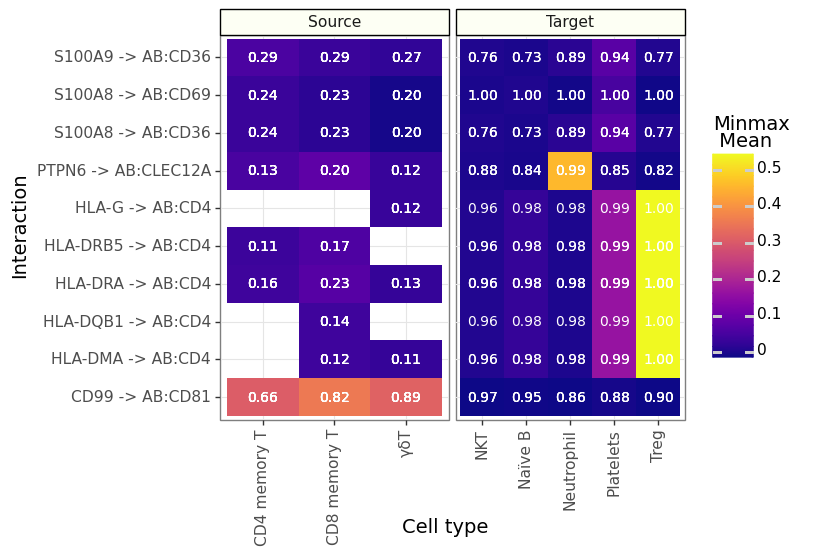

<ggplot: (8777485191295)>

In [113]:
(my_plot +
 p9.labs(fill='Minmax\n Mean\n')
)

In [128]:
my_plot = li.pl.dotplot(adata = mdata,
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=effectors,
              target_labels=targets,
              figure_size=(8, 7),
              filterby='cellphone_pvals',
              filter_lambda=lambda x: x < 0.05,
              top_n=10,
              size_range=(0, 5),
              orderby='lr_means',
              orderby_ascending=True,
              cmap='Reds',
             )


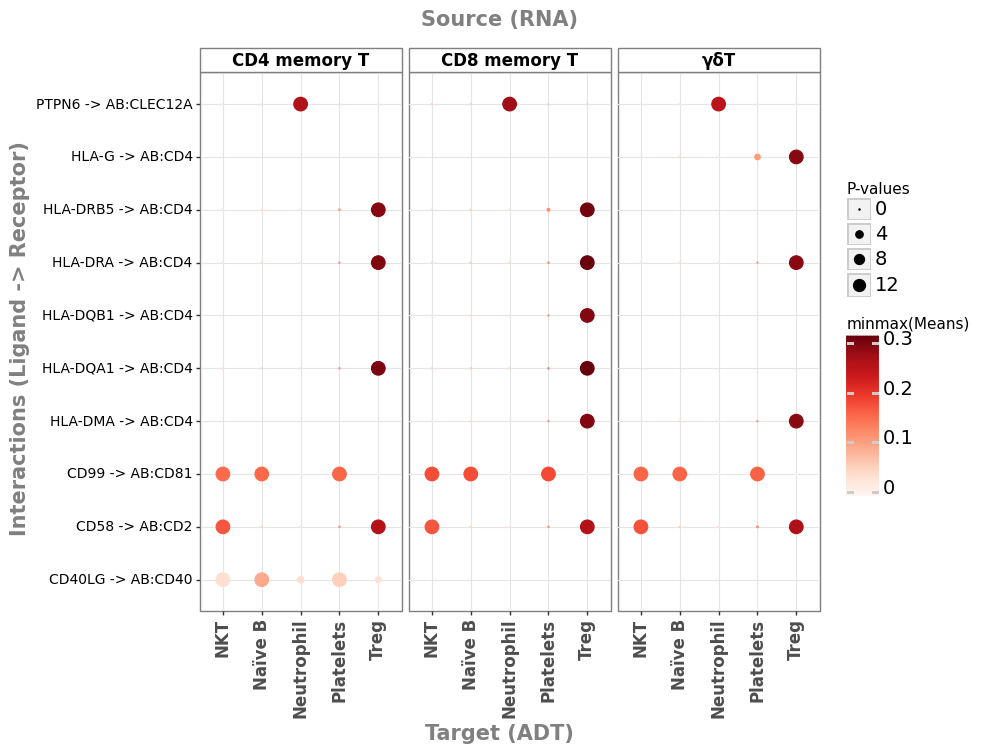

<ggplot: (8777485896647)>

In [130]:
(
    my_plot + 
    # x labe
    p9.labs(x = "Target (ADT)", title = "Source (RNA)", colour = 'minmax(Means)', size='P-values') +
    # x and title font is the same
    p9.theme(axis_text_x = p9.element_text(size = 12),
             axis_title_x = p9.element_text(size = 15, color='gray', face="bold"),
             plot_title = p9.element_text(size = 15),
             strip_text=p9.element_text(size=12, colour="black", face="bold")
             )

)